## Overview

Accurate prediction of stock market asset is a significant and challenging task due to complicated nature of the financial stock markets. Considering the increasing availability and affordability of powerful computational engines, deep learning methods of prediction have proved its efficiency in finance.

## Business Understanding

A time series regression model using NN or other advanced techniques is built to predict the stock market. Stock market prediction aims to determine the future movement of the stock value of a financial exchange. This project is helpful for Stock investors and investment banks to have a better understanding in developing economical Strategy and in making financial decisions.

### Import Packages

In [1]:
import twint

import nest_asyncio
nest_asyncio.apply()

import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mbcn345/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Twint

In [2]:
%%capture
# Configuring Twint to search for the subject in the first specified city
c = twint.Config()

# The amount of tweets to return sorted by most recent
c.Limit = 200

# Input parameters
c.Search = "$AAPL"

# Removing retweets
c.Filter_retweets = True

# No pictures or video
c.Media = False

# English only
c.Lang ='en'

# Excluding tweets with links
c.Links ='exclude'

# Making the results pandas friendly
c.Pandas = True

twint.run.Search(c)

# Assigning the DF
df = twint.storage.panda.Tweets_df

In [4]:
df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1402537700075393026,1402537700075393026,1.623226e+12,2021-06-09 04:07:00,-0400,,Best stocks to get at 4AM! $CLOV $NEXT $GME $...,en,[],"[clov, next, gme, amc, f, wish, itub, wkhs, aapl]",...,,,,,,[],,,,
1,1402535947393134593,1402535947393134593,1.623226e+12,2021-06-09 04:00:02,-0400,,Best stocks to get at 4AM! $CLOV $NEXT $GME $...,en,[],"[clov, next, gme, amc, f, wish, itub, wkhs, aapl]",...,,,,,,[],,,,
2,1402520392066011137,1402158634361049089,1.623222e+12,2021-06-09 02:58:13,-0400,,@sterlingredpill @kweiner01 For my part I'd ju...,en,[],[aapl],...,,,,,,"[{'screen_name': 'sterlingredpill', 'name': 'S...",,,,
3,1402516204938485764,1402516204938485764,1.623221e+12,2021-06-09 02:41:35,-0400,,Moved 30% off the $CLOV money into $AAPL. Leav...,en,[],"[clov, aapl]",...,,,,,,[],,,,
4,1402512030758748163,1402512030758748163,1.623220e+12,2021-06-09 02:25:00,-0400,,Best stocks to get at 4AM! $CLOV $NEXT $GME $...,en,[],"[clov, next, gme, amc, f, wish, itub, wkhs, aapl]",...,,,,,,[],,,,


In [7]:
def sentiment_class(score):
    """
    Labels each tweet based on its sentiment score
    """
    if score > 0: score = "Positive"
    elif score < 0: score ='Negative'
    else: score = 'Neutral'
        
    return score

In [8]:
# Instantiating the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Grabbing the sentiment scores and assigning them to a new column
df['sentiment'] = [sid.polarity_scores(df.tweet.iloc[i])['compound'] for i in range(len(df))]

# Labeling the tweets in a new column
df['feel'] = df.sentiment.apply(sentiment_class)

In [18]:
df.feel.value_counts()

Positive    100
Neutral      76
Negative     24
Name: feel, dtype: int64

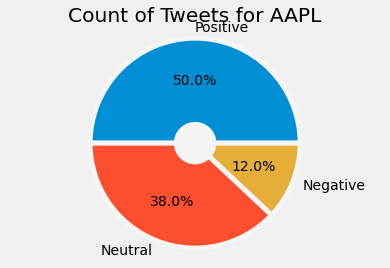

In [20]:
plt.style.use('fivethirtyeight')
#plt.rcParams['font.size'] = 30
fig, ax = plt.subplots()

ax.pie(list(df.feel.value_counts()), 
       labels=df.feel.value_counts().index, 
       autopct='%1.1f%%',
       wedgeprops = { 'linewidth': 5, 'edgecolor': 'whitesmoke' })

circle = plt.Circle((0,0), 0.2, color='whitesmoke')
fig = plt.gcf()
fig.gca().add_artist(circle)

ax.set_title(f"Count of Tweets for AAPL")
ax.axis('equal')
#plt.savefig('images/count.jpeg', format='jpeg')

Text(0, 0.5, '# of Tweets')

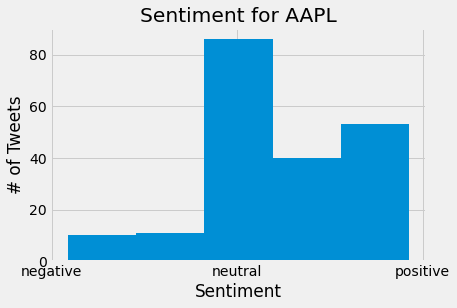

In [24]:
fig, ax = plt.subplots()

# Plotting the sentiment scores
ax.hist(df['sentiment'], bins=5)

plt.title(f"Sentiment for {'AAPL'}")
ax.set_xticks([-1,0,1])
ax.set_xticklabels(['negative', 'neutral', 'positive'])
plt.xlabel("Sentiment")
plt.ylabel("# of Tweets")
#plt.savefig('images/sentiment.jpeg', format='jpeg')

In [33]:
def twint_to_pandas(columns):
    return twint.output.panda.Tweets_df[columns]

In [34]:
df_pd = twint_to_pandas(["date", "username", "tweet", "hashtags", "nlikes"])

In [37]:
df_pd.head()

,date,username,tweet,hashtags,nlikes
0,2021-06-09 04:07:00,EdgarPatience1,Best stocks to get at 4AM! $CLOV $NEXT $GME $...,[],0
1,2021-06-09 04:00:02,RonaldBrooke3,Best stocks to get at 4AM! $CLOV $NEXT $GME $...,[],1
2,2021-06-09 02:58:13,franzvonloewe,@sterlingredpill @kweiner01 For my part I'd ju...,[],0
3,2021-06-09 02:41:35,ralphvandenhoek,Moved 30% off the $CLOV money into $AAPL. Leav...,[],0
4,2021-06-09 02:25:00,TristaW27485591,Best stocks to get at 4AM! $CLOV $NEXT $GME $...,[],2


### Analyze sentiment of tweets

In [25]:
from textblob import TextBlob
from IPython.display import Markdown, display

In [26]:
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [108]:
for tweet in df_pd.tweet:
    print(tweet)
    analysis = TextBlob(tweet)
    print(analysis.sentiment)
    if analysis.sentiment[0] > 0:
        printmd('Positive', color = "green")
    elif analysis.sentiment[0] < 0:
        printmd('Negative', color = "red")
    else:
        printmd("Neutral", color = "grey")
        print("")

Best stocks to get at 4AM!  $CLOV $NEXT $GME $AMC $F $WISH $ITUB $WKHS $AAPL  REMEMBER Only Webull lets you trade from 4AM to 8PM EST! (MOST out of EVERY broker!)  Sign up for Webull using the link in my BIO &amp; you will get 2 FREE stocks worth up to $2300!  ~~ c
Sentiment(polarity=0.39999999999999997, subjectivity=0.45)


<span style='color:green'>Positive</span>

Best stocks to get at 4AM!  $CLOV $NEXT $GME $AMC $F $WISH $ITUB $WKHS $AAPL  REMEMBER Only Webull lets you trade from 4AM to 8PM EST! (MOST out of EVERY broker!)  Sign up for Webull using the link in my BIO &amp; you will get 2 FREE stocks worth up to $2300!  -- k
Sentiment(polarity=0.39999999999999997, subjectivity=0.45)


<span style='color:green'>Positive</span>

@sterlingredpill @kweiner01 For my part I'd just say that nobody was complaining about price manipulation in 2011.  People just love to buy stuff that is already going up. Like $AAPL etc.  I'm with Warren Buffet. I like to buy my hamburgers when they're on sale.
Sentiment(polarity=0.5, subjectivity=0.6)


<span style='color:green'>Positive</span>

Moved 30% off the $CLOV money into $AAPL. Leave the rest on the side for later use.   @OwnTheChaos @FatmanZoom
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Best stocks to get at 4AM!  $CLOV $NEXT $GME $AMC $F $WISH $ITUB $WKHS $AAPL  REMEMBER Only Webull lets you trade from 4AM to 8PM EST! (MOST out of EVERY broker!)  Sign up for Webull using the link in my BIO &amp; you will get 2 FREE stocks worth up to $2300!  --- b
Sentiment(polarity=0.39999999999999997, subjectivity=0.45)


<span style='color:green'>Positive</span>

High-return trading strategies available at Profectus Systems $AAPL $TSLA $VIX $SPY $SPX $UVXY $VXX $XIV $MSFT $AMZN $FB $INTC $GOOGL $T $VZ
Sentiment(polarity=0.4, subjectivity=0.4)


<span style='color:green'>Positive</span>

@okeydon 🍏 $AAPL より、 ティム・ホットクックが新発売!! される かも!? しれないかも!?ね(笑) ワン🐶🐾
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Best stocks to get at 4AM!  $CLOV $NEXT $GME $AMC $F $WISH $ITUB $WKHS $AAPL  REMEMBER Only Webull lets you trade from 4AM to 8PM EST! (MOST out of EVERY broker!)  Sign up for Webull using the link in my BIO &amp; you will get 2 FREE stocks worth up to $2300!  ~~ b
Sentiment(polarity=0.39999999999999997, subjectivity=0.45)


<span style='color:green'>Positive</span>

Best stocks to get at 4AM!  $CLOV $NEXT $GME $AMC $F $WISH $ITUB $WKHS $AAPL  REMEMBER Only Webull lets you trade from 4AM to 8PM EST! (MOST out of EVERY broker!)  Sign up for Webull using the link in my BIO &amp; you will get 2 FREE stocks worth up to $2300!  -- bb
Sentiment(polarity=0.39999999999999997, subjectivity=0.45)


<span style='color:green'>Positive</span>

Med tanke på att $aapl ska nu lägga in dörrnycklar i "wallet" för eg hotel också, vad tror vi utsikterna för tex $Zaplox ? #finanstwitter
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Its better to avoid $RIDE for the Financial Position it is currently in to. #Cash_is_king for any Business, I mean look at $AAPL
Sentiment(polarity=0.046875, subjectivity=0.396875)


<span style='color:green'>Positive</span>

$AAPL も $DKNG も微益、、それぞれATHまではキープしたい！
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


GARP seems to be holding up best in the new anti-tech regime. However, it is a mixed bag, w $AAPL and $AMZN stagnating after reporting huge growth at scale. I’m staying long and think they’ll have to be re-rated upward if earnings don’t slow down by end of year
Sentiment(polarity=0.14725829725829723, subjectivity=0.42763347763347753)


<span style='color:green'>Positive</span>

@jhuntermav *edit - I didnt notice he wrote "since january"  Either way.  If you look at the value of $aapl with its splits combined, you can see $amc #amc is still heavily undervalued at this point and the squeeze has yet to be squoze
Sentiment(polarity=-0.2, subjectivity=0.5)


<span style='color:red'>Negative</span>

@jhuntermav I didnt notice the since January.   Can happen when youre skimming tweets.  Relax buddy.  At least people can fully grasp the price/value of $aapl based on my response.
Sentiment(polarity=-0.3, subjectivity=0.4)


<span style='color:red'>Negative</span>

Portfolio update  Long -  $AAPL $ABNB $AMD $AMZN $ARKG $ASML $CRWD $DIS $DKNG $FB $FUTU $GS $JD $LRCX $MELI $NIO $NVDA $PENN $PINS $PLTR $RH $ROKU $SE $SNOW $SOFI $SQ $TDOC $TSLA $TWLO $TWTR  $UBER  Still renting cyclical ETFs $XLE $XLF $XLI $XLB as rotation drags on  YTD +5%
Sentiment(polarity=-0.05, subjectivity=0.4)


<span style='color:red'>Negative</span>

You are invited to test drive TradeIdeas PREMIUM features for 2 weeks!  $SPAQ $JAKK $IDEX $BOXL $TSLA $NKLA $HYLN $HTZ $SPCE $WKHS $AAPL $FB $KO $FB $SIRI $FIS $V $TMUS $FISV $INFO $MLCO $HRL
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Best stocks to get at 4AM!  $CLOV $NEXT $GME $AMC $F $WISH $ITUB $WKHS $AAPL  REMEMBER Only Webull lets you trade from 4AM to 8PM EST! (MOST out of EVERY broker!)  Sign up for Webull using the link in my BIO &amp; you will get 2 FREE stocks worth up to $2300!  --- a
Sentiment(polarity=0.39999999999999997, subjectivity=0.45)


<span style='color:green'>Positive</span>

@FocusedCompound Whenever I think about Porter’s five forces and ROIC, I always think about $AAPL and how strong they are in each category. One of the reasons Buffett is a fan.
Sentiment(polarity=0.4333333333333333, subjectivity=0.7333333333333333)


<span style='color:green'>Positive</span>

@jhuntermav Then squeeze $AAPL next please? I could use a lot of help with my $AAPL $180 Sept calls. Thanks in advance!
Sentiment(polarity=0.125, subjectivity=0.1)


<span style='color:green'>Positive</span>

Please allow me to put $AMC growth in perspective.  If $AAPL increased at the same rate as $AMC since January, $AAPL would be trading at $3,276 per share  Oh, and the squeeze hasn’t even started yet #MOASS
Sentiment(polarity=0.0, subjectivity=0.125)


<span style='color:grey'>Neutral</span>


Learn How To Trade  $TSLA $AMZN $AAPL $CLOV $NVDA #trading #investing
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


$mara $sklz $tsla $opti $spy $srne $coin $fubo $spce  $dkng $penn $aapl $ibio $mvis $amc $ocgn $pltr $wkhs $msft $vxrt $coin $sndl $acb $fb $nio $cciv $snap  $nakd $gme  WE ALERTED $FSR at $10 RAN TO $30 (200% GAIN)   DAILY ALERTS  $15 ONE TIME FEE  BEAT THAT 👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@UnravelTrading $AAPL It tried to run out of the gate but had major resistance on the daily at the 50  &amp; 100ma.  Catalyst: EV battery news. New products and services demonstrated at the developer conference yesterday.
Sentiment(polarity=0.06628787878787878, subjectivity=0.3181818181818182)


<span style='color:green'>Positive</span>

@heydave7 Apple should simply do what Berkshire did with them but with Tesla. Buy a stake and ensure a piece of the market. Berkshire bought apple stock at a valuation far higher then Tesla is currently. It’s not to late for apple to take a stake. $aapl $tsla
Sentiment(polarity=0.125, subjectivity=0.6142857142857143)


<span style='color:green'>Positive</span>

Dropped my iPhone in the hot tub and pull it out  after a few seconds to find it’s working completely fine lol. Thank you @apple $aapl
Sentiment(polarity=0.31666666666666665, subjectivity=0.5375000000000001)


<span style='color:green'>Positive</span>

$RKT $SOFI $WISH $AMC - tomorrow. $SHOP $AAPL - on the big names lets see how they do.  Next time AAPL breaks that 128 it will run super fast to 130. IV is extremely low on it so can make a double very fast
Sentiment(polarity=0.11333333333333333, subjectivity=0.3495238095238095)


<span style='color:green'>Positive</span>

@PeterTrader99 Sir can you pls share abt $aapl ? Are we seeing 132 by EOW
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


#chartrequests #TONIGHT   Drop the ticker in comments which you think is about to make a move  - one ticker per account  - will chart the best setups  $spy $spx $aapl $tsla $ttd
Sentiment(polarity=1.0, subjectivity=0.3)


<span style='color:green'>Positive</span>

After today’s $XOM rally basically sealing off any chance of it not being an impulse, and things like $AAPL looking ready to start a W-3 down of CPI and a slightly, but not significantly widening credit market... I am way too bearish again. Oh well.
Sentiment(polarity=-0.07743055555555556, subjectivity=0.45763888888888893)


<span style='color:red'>Negative</span>

$mara $sklz $tsla $opti $spy $srne  $coin $fubo $penn $dkng $aapl $ibio $mvis $pltr $wkhs $coin $fsr $msft $sndl $acb $fb $amc $nio $wish $cciv $nakd $gme  $eegi $vxrt  WE ALERTED $BLNK at $6 RAN TO $30 (400% GAIN)  DAILY ALERTS  $15 ONE TIME FEE  BEAT THAT  👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@heydave7 I wonder why $TSLA don’t beat $AAPL and start a Tesla iPhone, they can do it and catch up fast 💨
Sentiment(polarity=0.2, subjectivity=0.6)


<span style='color:green'>Positive</span>

Ignore this testing something:  $SPY $AAPL $FB $BRK.A $SNAP $TSLA $NVDA $V
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Watchlist (TBD)  $AMZN $AAPL $MSFT $TSLA $BA Want to watch big names hold their levels &amp; not break below major support  $WKHS $ROOT $CLOV $CLVS All the memes &amp; high short float 👀 for accumulation then OTF up  $XLE $XME $XLK S&amp;P sectors  $XLRE as risk off indicator  $JETS $XAR 👀
Sentiment(polarity=0.055625, subjectivity=0.36)


<span style='color:green'>Positive</span>

@StratusYoung @SleepwellCap 100% but I think $aapl is tricky. I don't want to make this comparison because I believe aapl is a far more established brand and company, but like $pton they have the consumer hardware business paired with fast growing Saas/services offerings
Sentiment(polarity=0.26666666666666666, subjectivity=0.7000000000000001)


<span style='color:green'>Positive</span>

$penn $mara $snap $fsr $sunw $tsla $opti $spy  $aapl $pltr $spce $srne $fb $cciv $aal $dkng $coin $mvis $sndl $nakd $coin $gme $fubo $bctx $amd $amc $wkhs $msft $nio  WE ALERTED $NOVN at $.50 RAN TO $1.30 (160% GAIN)  DAILY ALERTS  $15 ONE TIME FEE  BEAT THAT 👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@SleepwellCap $AAPL is consumer not tech. Too many people say it’s a tech company when it’s not much more than a consumer brand that just so happens to sell electronics.
Sentiment(polarity=0.125, subjectivity=0.5)


<span style='color:green'>Positive</span>

$AAPL many call options opened for $132 by 6/18. 🚀🚀🚀🚀🚀
Sentiment(polarity=0.5, subjectivity=0.5)


<span style='color:green'>Positive</span>

@katbaker2017 Wait until $AAPL iStore revenue is cut by 66%.
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@heydave7 @WholeMarsBlog +100 #AppleEVRumorUpdate! 06.08.2021  (Hashtag Time Line Tracking #AppleEV &amp; #ProjectTitan Rumors Since 2015)  @Apple  $AAPL
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


$AAPL similar candles prior to last run to $135. If it follows thru, $SPY ATH.  If not, market probably correcting. jmo
Sentiment(polarity=0.0, subjectivity=0.15555555555555556)


<span style='color:grey'>Neutral</span>


This, plus the action in $spy $qqq and $xlf is why, even tho some big implosion is somewher in the next 3 to 12 months, I took that $aapl #long
Sentiment(polarity=0.0125, subjectivity=0.15000000000000002)


<span style='color:green'>Positive</span>

🇺🇸 U.S. Stock Analyst Ratings and Price Targets $AAP → t $185-$215 | Buy $AAPL → t $130 | Neutral $AKR → t $20-$25 | Overweight $ALLT → t $20-$22 | Buy $AM → Buy → Hold $AMH → t $38-$40 | Equal Weight $AMT → t $275-$285 | Overweight  *t = Price Target
Sentiment(polarity=0.0, subjectivity=0.25)


<span style='color:grey'>Neutral</span>


@heydave7 We don’t even know if $AAPL thinks to kill $TSLA. These are wild stories propagated for hits. $AAPL can make something that is used in future cars. They have enough money to research. There is enough space in EV for multiple companies.
Sentiment(polarity=0.02, subjectivity=0.305)


<span style='color:green'>Positive</span>

The SMA Versus The EMA: Which One Is Better?  $TSLA $AMZN $AAPL $CLOV $NVDA #trading #investing
Sentiment(polarity=0.5, subjectivity=0.5)


<span style='color:green'>Positive</span>

@heydave7 I would say yes if were not $AAPL
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@heydave7 well said Dave! $aapl sounds like a formidable competitor, which it is because of its software expertise. But to succeed in the EV game, one needs to be fully vertically integrated like $tsla. I do not think $aapl is ready for that type of capital intensity game.
Sentiment(polarity=-0.20000000000000004, subjectivity=0.43333333333333335)


<span style='color:red'>Negative</span>

@rationalwalk The best example of loyal customers I can think of?   $AAPL   So many people will only own an IPhone for the rest of their lives.
Sentiment(polarity=0.48666666666666664, subjectivity=0.7266666666666667)


<span style='color:green'>Positive</span>

@FishTrades642 There are several thriving corporations and stocks that would disagree. $AAPL $GOOGL $MSFT $BRK.A etc all have great success with it. The Buffet thesis on it is interesting. As for idea pipelines I don't pretend to know but safe to say $ETSY not depleted with growth yet.
Sentiment(polarity=0.42000000000000004, subjectivity=0.35)


<span style='color:green'>Positive</span>

@ManiP86 @MajorStocks Add $AAPL at any price and keep adding. You’ll never regret it. They print money and will continue to innovate and grow. 🍎🚗
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@DereckCoatney Leading names are starting to make bear flags. $tsla and $aapl both look like they want to tumble.
Sentiment(polarity=0.0, subjectivity=0.1)


<span style='color:grey'>Neutral</span>


$AAPL RANGE HIGH: $131.67 [3.89%] RANGE LOW: $123.23 [-2.77%]  PREVIOUS CLOSE: $126.74 TRADE - NEUTRAL TREND - BEARISH
Sentiment(polarity=-0.002222222222222218, subjectivity=0.33555555555555555)


<span style='color:red'>Negative</span>

@jablamsky @qcapital2020 $clpt $cmlf $twst $haac $aapl $dmtk
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@MajorStocks $AAPL almost like an index fund for me at this point. You can buy really anytime up or down and cash out in 10+ years and be extremely happy about it.
Sentiment(polarity=0.2814814814814815, subjectivity=0.4962962962962963)


<span style='color:green'>Positive</span>

@heydave7 $AAPL will not deliver a single EV by 2025, so they remain irrelevant to this space.
Sentiment(polarity=-0.2857142857142857, subjectivity=0.6071428571428571)


<span style='color:red'>Negative</span>

$mara $sklz $tsla $opti $spy $srne $coin $fubo $penn $dkng $aapl $ibio $mvis $pltr $wkhs $coin $fsr $msft $sndl $acb $fb $amc $nio $wish $cciv $nakd  $gme  $eegi $vxrt  WE ALERTED $BLNK at $6 RAN TO $30 (400% GAIN)  DAILY ALERTS  $15 ONE TIME FEE!  BEAT THAT  👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@barrishta $AAPL has to first struggle w/ tax increase both domestically &amp; internationally, but it will get over it.
Sentiment(polarity=0.125, subjectivity=0.16666666666666666)


<span style='color:green'>Positive</span>

08.06 // Top Volume Traders (Large Cap) 🚀🌕  $AMC $PBR $ITUB $AAPL
Sentiment(polarity=0.35714285714285715, subjectivity=0.4642857142857143)


<span style='color:green'>Positive</span>

My PF コア 🇯🇵 9434.T 800@1,242円 🇺🇸 $RPRX 335@42ドル 🇺🇸 $AAPL 400@101 🇺🇸 $TSLA 32@378 🇺🇸 $PINS 230@38 🇺🇸 $U 150@140 🇺🇸 $NET 280@33 🇺🇸 $SQ 113@130 🇸🇬 $SE 112@169 🇨🇳 $NIO 560@35 🇨🇳 $NIU 300@44 🇨🇳 $TIGR 600@26
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@BuzFed Personally I’d be more concerned with $AAPL competing in autonomy rather than Waymo. They never innovated at a fast enough pace to stay in the game.
Sentiment(polarity=0.07499999999999998, subjectivity=0.5)


<span style='color:green'>Positive</span>

What if I told you, you could just trade $AAPL and earn a living.....Trading only 1 stock.  It's true.
Sentiment(polarity=0.175, subjectivity=0.825)


<span style='color:green'>Positive</span>

$mara $sklz $tsla $opti $spy $srne $coin $fubo $spce  $dkng $penn $aapl $ibio $mvis  $amc $ocgn $pltr $wkhs $msft $vxrt $coin $sndl $acb $fb $nio $cciv $snap $nakd $gme  WE ALERTED $FSR at $10 RAN TO $30 (200% GAIN)   DAILY ALERTS  $15 ONE TIME FEE  BEAT THAT 👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


$AAPL Today Apple kicked of WWDC '21. Put simply, the breadth of Apple's enhancements across iOS 15, iPadOS 15, WatchOS 8, macOS Monterey, etc. are nothing short of impressive - Wells Fargo OW PT $160
Sentiment(polarity=0.3333333333333333, subjectivity=0.5523809523809523)


<span style='color:green'>Positive</span>

@TrendSpider Added some $AAPL today Dan. Will see
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@TrendSpider $AAPL what a loser so far this year… I guess they need to invent a new color and launch the same lookin iphone and stock May go up then
Sentiment(polarity=0.07878787878787878, subjectivity=0.5265151515151515)


<span style='color:green'>Positive</span>

...then build a battery factory to continue down the river. The ceiling is much higher now...don't try to be $Alb, go become $Aapl. Build a battery "college" campus that recruits the best in clean energy. It's go time.
Sentiment(polarity=0.36527777777777776, subjectivity=0.4472222222222223)


<span style='color:green'>Positive</span>

@PuffDragon11 $AAPL chart is awful too 📉📉
Sentiment(polarity=-1.0, subjectivity=1.0)


<span style='color:red'>Negative</span>

@moomjuice $AAPL and $MSFT too no?
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@LiviamCapital Agreed. But they went down for no reason. There is no more value investing, people don’t like $AAPL any more. I am only supporting this Reddit rallies for the sake of small investors. I believe these are the people who spend in our economy. Someone is standing up to these shorts.
Sentiment(polarity=0.01574074074074074, subjectivity=0.48981481481481476)


<span style='color:green'>Positive</span>

@Discover_Divs First dividend payment was $AAPL for $2.10.  Since then, the biggest dividend I’ve ever received hasn’t been anything bigger than the $2.10.
Sentiment(polarity=0.125, subjectivity=0.41666666666666663)


<span style='color:green'>Positive</span>

@BahamaBen9 TSLA 452%/143% $SQ 419%/252% $RDFN 404%/265% $SE 295%/474% $PINS 228%/268% $SHOP 224%/749% $ROKU 196%/231% $ZS 188%/310% $CRWD 182%/138% $PTON 144%/35% $MELI 136%/66% $TTD 128%/188% $DOCU 112%/128% $AAPL 89%/240% Bens/ my returns are based on highest buy as I’ve added to some.
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


I am not calling any top or bottom, just stay cautions on the market to go long here and if you are in FOMO, just get hedged and don't get fk'ed. #stocks #SPX $NDX #ES_F #NQ_F $AMZN $AAPL $GOOGL $TSLA $GME $AMC $CLOV $WISH Good Luck everyone...
Sentiment(polarity=0.3833333333333333, subjectivity=0.5)


<span style='color:green'>Positive</span>

@ThetaWarrior Do you see $AAPL continuing to that 131 target?
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Tomorrow on Instagram I will do the #630club live featuring @Trendspider_J charts. I’ll learn all the bells and whistles as I go. Tune in! Join ScottRedlerT3 on Instagram as I do it each morning @TrendSpider  $spx $qqq $btc $clov $wish $qs $amzn $aapl
Sentiment(polarity=0.17045454545454544, subjectivity=0.5)


<span style='color:green'>Positive</span>

@thenewsoncnbc @CNBC @LesliePicker Yeah $AAPL hasn’t put me on the board yet either. They must not be practicing diversity. I got a “Good Enough Degree”😂
Sentiment(polarity=0.35, subjectivity=0.55)


<span style='color:green'>Positive</span>

@feng_wesley @ThorYoung @BearBullTraders And yet another great $AAPL trade today from an @BearBullTraders member!
Sentiment(polarity=1.0, subjectivity=0.75)


<span style='color:green'>Positive</span>

@MarcusLeong26 Another great $AAPL trade from a @BearBullTraders member!
Sentiment(polarity=1.0, subjectivity=0.75)


<span style='color:green'>Positive</span>

Taking a step back from the madness. What sector is not moving or even falling right now? Or what specific stocks ? Looking for next best opportunity   $ATER $TSLA $SE $CCIV $PLTR $LOTZ $NET $RSI $TDOC $PTON $SQ $ROKU $AAPL $GOOG $BA $BABA $SHOP
Sentiment(polarity=0.21428571428571427, subjectivity=0.1601190476190476)


<span style='color:green'>Positive</span>

@LA_AM_Trader @BearBullTraders I love seeing all these great $AAPL trades from BBT members.
Sentiment(polarity=0.65, subjectivity=0.675)


<span style='color:green'>Positive</span>

#ES_F #ES $SPX $SPY  We are in a range of 4205-4236.   Breakout above 4236 leads to 🎯 4267 and 🎯 4300  Breakout below 4205 leads to 🎯4174  and 🎯4143  For 9/6/21   Long above ⬆️ 4222  Short below⬇️ 4220  #NQ #DAX $AMC $GME #GME $AAPL $TSLA $FB $BBBY $MSFT
Sentiment(polarity=-0.0125, subjectivity=0.22499999999999998)


<span style='color:red'>Negative</span>

Best stocks to get at 4AM!  $CLOV $NEXT $GME $AMC $F $WISH $ITUB $WKHS $AAPL  REMEMBER Only Webull lets you trade from 4AM to 8PM EST! (MOST out of EVERY broker!)  Sign up for Webull using the link in my BIO &amp; you will get 2 FREE stocks worth up to $2300!  ~ d
Sentiment(polarity=0.39999999999999997, subjectivity=0.45)


<span style='color:green'>Positive</span>

Something is extremely fishy about these financial times. I parked some cash in $GOOG $TSLA $DIS $AAPL $BLK $MRK $ETSY $RTX $LMT $NOC $BA $SBUX $NKE $JPM $TWTR $AQMS $MCD $ROKU $HD $WDFC $CMG $DXS $PEP $HSY $SNDL $HD $DFS for the most part. These are solid positions. #StockMarket
Sentiment(polarity=0.09375, subjectivity=0.4)


<span style='color:green'>Positive</span>

@CryptoParadyme $AAPL
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Where is $tsla going tomorrow (NO BS)  $spy $aapl $fb $nflx $amzn $googl $zm $jpm $gs $gld $nvax $slv $wmt $bac $baba $aal $dal $nk $ba $ng $solo $ayro $nkla $nio $spaq $trxc $chek $pte  $rscf $zom $nakd $ctrm $sndl $amc $axas $doge
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Largest positions in order:   $NTDOY  $AAPL $FB $ADSK  $SFTBY  Looking to add $ADBE to that list soon. Hopefully $NOC or $LMT too
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


DeMark indicators for 2021-06-09 :   $AAPL : range 126.48 - 128.72 $AMZN : range 3241.25 - 3302.39 $FB : range 329.93 - 335.99 $GOOG : range 2475.54 - 2501.80 $MSFT : range 250.80 - 254.29 $NFLX : range 486.15 - 495.60  #Faang
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


If stocks were NFL Quarterbacks:  $AAPL = Tom Brady: I’ll stop here…🐐  $KO = Dak Prescott: Consistent &amp; very reliable but never AMZN  $GME = Jameis Winston: flashes of brilliance but overall crap  $AMZN in 1999: Baker Mayfield - Lots of controversy but on the verge of greatness
Sentiment(polarity=-0.08750000000000001, subjectivity=0.3375)


<span style='color:red'>Negative</span>

- Thank you Fintwit community - ❤️ You've helped my family! ❤️  My best performers over last 15 months  $TSLA 452% $SQ 419% $RDFN 404% $SE 295% $PINS 228% $SHOP 224% $ROKU 196% $ZS 188% $CRWD 182% $PTON 144% $MELI 136% $TTD 128% $DOCU 112% $AAPL 89%  Please share your winners 👇
Sentiment(polarity=0.5, subjectivity=0.18333333333333332)


<span style='color:green'>Positive</span>

1/3 of $f volume   1/6 of $siri volume 1/2 of $t volume  1/4 of $aapl volume from dark pool today
Sentiment(polarity=-0.15, subjectivity=0.4)


<span style='color:red'>Negative</span>

@BrianFeroldi All the stocks I own are amazing. I would feel sorry for people who made fun of them. $MSFT $AAPL #JNJ $HON $VYM $DIS
Sentiment(polarity=0.25000000000000006, subjectivity=0.775)


<span style='color:green'>Positive</span>

@lorraine_matt @TrendSpider @kingblehme Haha you and I both! You know the contents of what I discuss for the most part, no different than what we've been talking about at @OptionsCharting. $OIH $AAPL $GPRO $IDRV $TSLA $GE
Sentiment(polarity=0.25, subjectivity=0.4666666666666666)


<span style='color:green'>Positive</span>

@MajorStocks If you like $AAPL check out the $AMZN chart
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


$mara $sklz $tsla $opti $spy $srne $coin $fubo $penn $dkng $aapl $ibio $mvis $wish $pltr $wkhs $coin $fsr $msft $sndl $acb $fb $amc $nio $cciv $nakd $gme $eegi $vxrt  WE ALERTED $BLNK at $6 RAN TO $30 (400% GAIN)   DAILY ALERTS  $15 ONE TIME FEE!   BEAT THAT  👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@MajorStocks What do you like most regarding $AAPL current price level?
Sentiment(polarity=0.25, subjectivity=0.45)


<span style='color:green'>Positive</span>

Dat was high for the day. De End #AAPL $AAPL $128.46 Now you know what the Universe gifted us with. #BTC ain't got chit on us as a tool for humanity. -DOH This is fast and furious, ain't no waiting and begging people to but. - SIgh LOL
Sentiment(polarity=0.41500000000000004, subjectivity=0.71)


<span style='color:green'>Positive</span>

【米株6/8】🇺🇸 $HON +0.7% ハネウェル、量子コンピューティング事業の分離計画を明らかに  $AAPL +0.6% EVバッテリー供給巡り中国企業と協議と報道  $FSLY +10% ファストリー、一時サービス障害が発生するも株価は上昇  $COUP -8% クーパ・ソフトウェア、決算発表後に一部アナリストが成長の懸念示す
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@unusual_whales @cnnbrk There was a 10,000 sweeper in $AAPL today
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


【日次】じっちゃま Fan Index 6/9 ・構成銘柄 31 YETI $YETI: 1.06% Twilio $TWLO: 0.92% Trade Desk $TTD: 0.84% Alphabet $GOOG: 0.68% Apple $AAPL: 0.67% Euronav $EURN: 0.68% BlackSky $SFTW: 0.6% DocuSign $DOCU: 0.56% OKTA $OKTA: 0.4%  (2/4)
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Nice moving AH for $AMZN could see a nice gap up tomorrow morning!   $AAPL $TSLA $BYND $QQQ
Sentiment(polarity=0.675, subjectivity=1.0)


<span style='color:green'>Positive</span>

◆個別 高値からの下落率 6/9 Zoom $ZM: -42.0% Tesla $TSLA: -33.0% Twitter $TWTR: -27.2% OKTA $OKTA: -26.1% Draftkings $DKNG: -25.7% Square $SQ: -24.4% PayPal $PYPL: -14.9% Apple $AAPL: -12.6% Amazon $AMZN: -8.2% Microsoft $MSFT: -4.0% Facebook $FB: -1.4% Google $GOOG: -0.5%  (4/4)
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


$penn $mara $snap $fsr $sunw $tsla $opti $spy $aapl $pltr $spce $srne $fb $cciv $aal $dkng $coin $mvis $sndl $nakd $coin $gme $fubo $bctx $amd $amc  $wkhs $msft $nio  WE ALERTED $NOVN at $.50 RAN TO $1.30 (160% GAIN)  DAILY ALERTS  $15 ONE TIME FEE  BEAT THAT 👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Are there any buyers left for $AAPL $NFLX $AMZN?   Mega caps with the best earnings we've ever seen while their stocks haven't moved in a year.   $FB and $GOOGL have completely decoupled from #FAANG trending vs AAN
Sentiment(polarity=0.3666666666666667, subjectivity=0.2333333333333333)


<span style='color:green'>Positive</span>

Large cap stocks ($10B+ market cap) with the most shares traded today  $AMC 213.1M shares BlackBerry $BB 161.3M Huntington $HBAN 157.3M Ford $F 93.3M Petrobras $PBR 87.7M $ITUB 77.9M Apple $AAPL 74.1M Sirius XM $SIRI 65.4M AT&amp;T $T 61.5M Palantir $PLTR 53.3M $NIO 50.2M $NOK 48.6M
Sentiment(polarity=0.35714285714285715, subjectivity=0.4642857142857143)


<span style='color:green'>Positive</span>

@mikeydaytrader Stock split took $AAPL to 125. And that was after an EXTAORDINARY multi-month move.  I remember traders rushing in calling Apple "cheap" not understanding there's simply more shares. My target is 90 freaking dollars.
Sentiment(polarity=0.45, subjectivity=0.6)


<span style='color:green'>Positive</span>

Anybody else disappointed in today's $AAPL candle?
Sentiment(polarity=-0.75, subjectivity=0.75)


<span style='color:red'>Negative</span>

Companies need a set of religious beliefs similar to those of $AAPL. Every stock needs a group of investors who believe in the principles of the company. $HMBL has the capability of writing the greatest story since Steve Jobs came onto the scene. #unicornofunicorns
Sentiment(polarity=0.3333333333333333, subjectivity=0.5499999999999999)


<span style='color:green'>Positive</span>

Current investment portfolio, 25 stocks $BLNK $CLNE $FUBO $IDEX $LI $MMNFF $NIO $RIDE $TSLA $XL $XPEV $AAPL $AMMJ $AMZN $BNGO $CLII $FCEL $FRSX $NNDM $PENN $PLUG $RMO $SPCE $WKHS $XL a few could be duds, but many are just getting started. Cheers people!
Sentiment(polarity=0.14166666666666666, subjectivity=0.3333333333333333)


<span style='color:green'>Positive</span>

@JasonStrambu @optionslion8 No, it’s also $AAPL (click images to see it full)
Sentiment(polarity=0.35, subjectivity=0.55)


<span style='color:green'>Positive</span>

@StaresAtCandles @BSchulz33868165 I refer to them as the next darlings to de-throne the FANG stocks.  Higher returns investing in fresh blood. Everyone &amp; there dog owns FANG &amp; next 6 months already priced in. $AAPL $amzn $FB $nflx $googl
Sentiment(polarity=0.1375, subjectivity=0.25)


<span style='color:green'>Positive</span>

$CLOV 1.475m (77% call 23% put) $AAPL 1.356m (80% call 20% put) $AMC 1.081m (62% call 38% put) $TSLA 821k (61% call 39% put) $WISH 562k (87% call 13% put) $BB 532k (79% call 21% put) $F 508k (79% call 21% put) $WKHS 426k (84% call 14% put)
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@ErikVoorhees @IamNomad @ledgerstatus There’s a phone 100x better then iPhone that is 100% designed in my brain. No prototype yet. $AAPL stock going to 0.
Sentiment(polarity=0.5, subjectivity=0.5)


<span style='color:green'>Positive</span>

$TSLA $SQ $SHOP $AAPL $AMZN $FB  Talk to me in 5 years 😎
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


-Whipsawed out of $wpg , small gain  -Added $Mags near LOD -Entered $mosy on HL looking for continuation -Holding $AAPL , looking to add on dip -Was watching $Leds and $Clwt , no entry
Sentiment(polarity=-0.075, subjectivity=0.4)


<span style='color:red'>Negative</span>

@Matty_JL $AAPL  Umm lemme guess  You put too much size on?
Sentiment(polarity=0.2, subjectivity=0.2)


<span style='color:green'>Positive</span>

損益-6.77%☔️☔️ 前日比+1.55%☀️ $NCNO $AAPL $AI $LAZR $FUBO
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Most active stocks in today's after-hours trading  Huntington $HBAN Intel $INTC Comcast $CMCSA Apple $AAPL Cisco $CSCO AT&amp;T $T Bristol Myers $BMY Tesla $TSLA $AMC Dynatrace $DT General Electric $GE Wendy's $WEN Verizon $VZ Pepsi $PEP Berkshire $BRK.B Host Hotels $HST $MPC $VST
Sentiment(polarity=0.13888888888888892, subjectivity=0.5333333333333333)


<span style='color:green'>Positive</span>

$mara $sklz $tsla $opti $spy $srne $coin $fubo $penn $dkng $aapl $ibio $mvis $pltr $wkhs $coin $fsr $msft $sndl $acb $fb $amc $nio $wish $cciv $nakd $gme  $eegi $vxrt  WE ALERTED $BLNK at $6 RAN TO $30 (400% GAIN)  DAILY ALERTS  $15 ONE TIME FEE!  BEAT THAT  👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


$LOTZ $AAPL $SPY
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@ahuevovo @glizzyoptions Lmaooooo if $aapl went to $200 by 2021 I would shit my pants let alone tomroorw
Sentiment(polarity=-0.2, subjectivity=0.8)


<span style='color:red'>Negative</span>

@StockDweebs do you think $AAPL will drop below $120? Trying to figure out if $126 is too high for an entry.
Sentiment(polarity=0.16, subjectivity=0.5399999999999999)


<span style='color:green'>Positive</span>

Who would you rather have as President of USA right now? $penn $dkng $tsla $doge $aapl $cgc $amzn
Sentiment(polarity=0.2857142857142857, subjectivity=0.5357142857142857)


<span style='color:green'>Positive</span>

Current holding: $ASTI $TSLA  Watchlist: $AAPL $ABNB $PENN
Sentiment(polarity=0.0, subjectivity=0.4)


<span style='color:grey'>Neutral</span>


$mara $sklz $tsla $opti $spy $srne $coin $fubo  $spce  $dkng $penn $aapl $ibio $mvis $amc $ocgn $pltr $wkhs $msft $vxrt $coin $sndl $acb $fb $nio $cciv $snap $nakd $gme  WE ALERTED $FSR at $10 RAN TO $30 (200% GAIN)   DAILY ALERTS  $15 ONE TIME FEE  BEAT THAT 👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@MIcapital2 Surprised by $AAPL relative to $MSFT but especially $GOOG given all of the media narratives. $FB, $MO, and $ABI make sense to me with $FB definitely being the most debatable
Sentiment(polarity=0.12, subjectivity=0.58)


<span style='color:green'>Positive</span>

@PeterTrader99 Closing those short term $AAPL calls was good decision
Sentiment(polarity=0.35, subjectivity=0.45000000000000007)


<span style='color:green'>Positive</span>

@RedDogT3 instead of looking at past prices (which say nothing about future prices), you can look at the PEG ratio of $AAPL and see it's extremely high, even without the cash balance.  So that's why it's not doing much.  It's fully valued and anyone's guess if it goes higher.
Sentiment(polarity=0.072, subjectivity=0.323)


<span style='color:green'>Positive</span>

@BashriTijara I have some 6/11 calls as well. I got in when $AAPL was $126. I can see $128-$130 if the market is favorable.
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


#ALTCOIN Sentiment  What's next for Altcoins as a whole?  $ETH $XRP $LINK $COMP $ADA $UNI $AAPL $TSLA $AMZN $SPY $QQQ $CRV $GLD $HBAR $NVDA $REN $BNB $VET $UPS $AVAX $SNX $FB $SOL $AMD $F $AAVE $SUSHI $THETA $EGLD $CAKE $DOT $ENJ #OOTT #DDTG #crypto #news #ethereum #bitcoin  #btc
Sentiment(polarity=0.1, subjectivity=0.2)


<span style='color:green'>Positive</span>

BTC Sentiment (Price $33600)  What's next for Bitcoin?  $ETH $XRP $LINK $COMP $ADA $UNI $AAPL $TSLA $AMZN $SPY $QQQ $CRV $GLD $HBAR $NVDA $REN $BNB $VET $UPS $AVAX $SNX $FB $SOL $AMD $F $AAVE $SUSHI $THETA $EGLD $CAKE $DOT $ENJ #OOTT #DDTG #crypto #news #ethereum #bitcoin #btc
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@katbaker2017 Saw $AAPL flipped red to green on the 1D and opened a summer play today.  Do you see the potential choppiness being AAPL specific or in the broader tech sector short-term? Curious to get other takes because it is a staple of the major indices as well😅
Sentiment(polarity=-0.05178571428571429, subjectivity=0.4714285714285714)


<span style='color:red'>Negative</span>

traded my $aapl phone for a samsung
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@isbkch I think I'll grow my $AAPL part. They're doing a great job creating a real social network with a privacy focused features
Sentiment(polarity=0.42500000000000004, subjectivity=0.425)


<span style='color:green'>Positive</span>

@griffy_grif @MannyMagoo I used to always sell $AAPL after WWDC and then buy going into fall refresh (about month prior). Worked like a charm.
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Most active after close: $NEXT : 53.74% $AMC : -0.73% $WEN : 20.03% $AAPL : 0.73% $BB : -0.32% $WKHS : 16.07% $WISH : 17.46% $F : -1.45% $SNDL : -1.72% $CLOV : 75.04%
Sentiment(polarity=0.12222222222222223, subjectivity=0.3666666666666667)


<span style='color:green'>Positive</span>

@WebsiteKen really??  $aapl $amd $visl  hopefully that does it
Sentiment(polarity=0.2, subjectivity=0.2)


<span style='color:green'>Positive</span>

Thinking about taking my $10,000 $AAPL position and doubling it to $20,000. Love where the share price is at right now. Super cheap.
Sentiment(polarity=0.37976190476190474, subjectivity=0.6255952380952381)


<span style='color:green'>Positive</span>

You can call this portfolio my savings account. I am better off putting money in this than keeping in bank.  $GOOG  $MSFT $BBY $AMZN $TAN $VYM $TGT $HD $WBA $AAPL $ABBV $STWD
Sentiment(polarity=0.5, subjectivity=0.5)


<span style='color:green'>Positive</span>

$mara $sklz $tsla $opti $spy $srne $coin $fubo $penn $dkng $aapl $ibio $mvis $rmed $pltr $wkhs $coin  $fsr $msft $sndl $acb $fb $amc $nio $cciv $nakd $gme $eegi $vxrt  WE ALERTED $BLNK at $6 RAN TO $30 (400% GAIN)  DAILY ALERTS  $15 ONE TIME FEE!   BEAT THAT  👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@moksha_defined @Apple I see this as being aligned not contrary. In health app, you have the ability to opt-out &amp; provide consent in many ways, don’t merge HC data w/ non-HC data, min data collected, &amp; use on-device processing bypassing $AAPL servers. iOS14.5 allows you to disbar apps from tracking you
Sentiment(polarity=0.5, subjectivity=0.5)


<span style='color:green'>Positive</span>

@DividendDollas This reminds of something I saw a few months back -  however much you are spending on a product you buy that same about of shares - so if you buy a new iPhone for $1000, you buy $1000 worth of $AAPL
Sentiment(polarity=0.07272727272727272, subjectivity=0.16325757575757577)


<span style='color:green'>Positive</span>

Number of leading stocks today: 0 $SPY $QQQ $FB $GOOGL $AMZN $AAPL #DailyStkLeaderCount #Bitcoin #BTC
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Well if you thinking that some stupid idiots exiting market at highs $SPY each day step by step:  You also may think you the smartest guy/gal who will always be a winner in a #bullmarket for long  $QQQ $TSLA $CRM $NVDA $SMH $AAPL $AMZN $GOOG $AMC $GME $JPM $XLE #ES_F $NQ_F
Sentiment(polarity=-0.55, subjectivity=0.7333333333333334)


<span style='color:red'>Negative</span>

@Puucktalk Haha $Btc maximalists are ignorant. Makes for good internet though. $amzn did ≈ 400bill in revenue in 2020? Add in $fb $wmt $aapl as companies that accept $Btc and in short order they would just own all the $Btc as they have the cash to supplement the flow easily.
Sentiment(polarity=0.38666666666666666, subjectivity=0.6066666666666667)


<span style='color:green'>Positive</span>

@cloudflare @eastdakota going to take a punt and say iCloud+ Private Relay egress is powered by Cloudflare Warp $NET $AAPL #WWDC21
Sentiment(polarity=0.0, subjectivity=0.1875)


<span style='color:grey'>Neutral</span>


@MemeInvestors 🤷‍♂️ why 9 months and not 9 years? Holding $AAPL is more profitable as a long term relationship (think dividend and as long as they produce cash like they do). But I guess everyone can do what they want with their money…
Sentiment(polarity=0.13333333333333333, subjectivity=0.43333333333333335)


<span style='color:green'>Positive</span>

I can't believe people think $AAPL knows how to make a good car.   They don't even know how to make good antennas.
Sentiment(polarity=0.7, subjectivity=0.6000000000000001)


<span style='color:green'>Positive</span>

Most active options:  $CLOV 1,404k - 24% put  76% call $AAPL 1,352k - 20% put  80% call $AMC 1,049k - 38% put  62% call $BB 526k - 21% put  79% call $TSLA 521k - 43% put  57% call $WISH 503k - 13% put  87% call $F 451k - 21% put  79% call $AMZN 372k - 32% put  68% call
Sentiment(polarity=0.18333333333333335, subjectivity=0.55)


<span style='color:green'>Positive</span>

Metamaterial Inc hits another all time high. $4.10. A sign of things to come after merger. Some of the best tech I've ever seen is in their pipeline. We are witnessing the birth of a future tech giant.  $mmatf $mmat $trch  $tsla $goog $aapl $qqq
Sentiment(polarity=0.29, subjectivity=0.49124999999999996)


<span style='color:green'>Positive</span>

Symbol : $AAPL 1 Day Vol Change: 8.02% 7 Day Vol Change: 9.56%  Powered By #VolumeFlow
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


$mara $sklz $tsla $opti $spy $srne $coin $fubo $spce  $dkng $penn $aapl $ibio $mvis $amc $ocgn $pltr $wkhs $msft $vxrt $coin $sndl $acb $fb $nio $cciv $snap  $nakd $gme  WE ALERTED $FSR at $10 RAN TO $30 (200% GAIN)   DAILY ALERTS  $15 ONE TIME FEE  BEAT THAT 👇👇 🚨LINK IN BIO🚨
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


#WallStreet 🇺🇸 Today #Options Volumes:  $CLOV 1.475m (77% call 23% put) $AAPL 1.356m (80% call 20% put) $AMC 1.081m (62% call 38% put) $TSLA 821k (61% call 39% put) $WISH 562k (87% call 13% put) $BB 532k (79% call 21% put) $F 508k (79% call 21% put) $WKHS 426k (84% call 14% put)
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Tuesday Options Volumes  $CLOV 1.475m (77% call 23% put) $AAPL 1.356m (80% call 20% put) $AMC 1.081m (62% call 38% put) $TSLA 821k (61% call 39% put) $WISH 562k (87% call 13% put) $BB 532k (79% call 21% put) $F 508k (79% call 21% put) $WKHS 426k (84% call 14% put)
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


$AAPL closed today at $126.74.  If you bought 1 share of #AAPL at its closing price every day this week, you’ve gained $0.84 (+0.33%).  If you bought 1 share of AAPL at its closing price every day this year, you’ve lost $197.07 (-1.42%).
Sentiment(polarity=-0.1, subjectivity=0.1)


<span style='color:red'>Negative</span>

Best stocks to get at 4AM!  $CLOV $NEXT $GME $AMC $F $WISH $ITUB $WKHS $AAPL  REMEMBER Only Webull lets you trade from 4AM to 8PM EST! (MOST out of EVERY broker!)  Sign up for Webull using the link in my BIO &amp; you will get 2 FREE stocks worth up to $2300!  = a
Sentiment(polarity=0.39999999999999997, subjectivity=0.45)


<span style='color:green'>Positive</span>

@squawksquare Don’t compare $aapl to $tsla
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@moksha_defined @Apple $AAPL would be the one who monetizes and will come in the form of API partnerships with HC orgs, EHR &amp; provider companies, but they’ll never be able to monetize your personal info. They also have the ability to “mask” the data stripping out PII for population health purposes, tho
Sentiment(polarity=0.25, subjectivity=0.4625)


<span style='color:green'>Positive</span>

$SOFI 🔥 ❤️ @Softbank 65M shares. 30$+ tomorrow.  Next Squeeze 🚀 40% short to cover.    #APES #ApeStrongTogether  💎🙌#wallstreetbets $GME $OCGN $CLOV 🔥 $QS 🔥 $TSLA $PLTR $AAPL $PTON $COIN $RIOT $AMD $VTNR $MARA $AMC $RKT $SNDL $BB $BNGO $WKHS $AAPL
Sentiment(polarity=0.0, subjectivity=0.15)


<span style='color:grey'>Neutral</span>


$AAPL Below Avg Volume Daily appearances since 2010: 1006 Close 5 days later ±: Avg: 0.37 SD: 2.61 Worst: -11.83 Best: 17.71  10 days later: Avg: 0.81 SD: 3.58 Worst: -14.39 Best: 18.82  30 days later: Avg: 2.21 SD: 6.90 Worst: -24.11 Best: 37.18
Sentiment(polarity=0.0, subjectivity=0.38999999999999996)


<span style='color:grey'>Neutral</span>


$AAPL Inverted Hammer Daily appearances since 2010: 72 Close 5 days later ±: Avg: 0.10 SD: 2.13 Worst: -5.69 Best: 5.66  10 days later: Avg: 0.42 SD: 2.82 Worst: -10.64 Best: 6.86  30 days later: Avg: 2.03 SD: 4.38 Worst: -9.00 Best: 13.80
Sentiment(polarity=0.0, subjectivity=0.38999999999999996)


<span style='color:grey'>Neutral</span>


La partida de inventarios juega un papel muy importante en la valoración de una compañía y poca gente de Wall Street le presta atención, solo quieren fijarse en los EPS.  #WallStreet #NASDAQ100 #invertir #Ibex35 $baba $amz $aapl $ftnt
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Fisker initiated with an Outperform at RBC Capital $FSR $AAPL
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Sold the following:  $AAPL 7/2 130C for 2.04 from 1.29 (+58.1%) $CRNC 7/16 110C for 14.00 from 9.20 (+52.2%) $CVAC 7/16 130C for 6.80 from 14.10 (-51.8%) $DAL 7/2 48C for 1.30 from 0.92 (+41.3%) $FSLR 7/2 83C for 0.43 from 0.97 (-55.7%) $PLTR 7/2 25C for 1.51 from 1.04 (+45.2%)
Sentiment(polarity=0.0, subjectivity=0.1)


<span style='color:grey'>Neutral</span>


$AAPL $AKAM $FSLY $NET Apple taps Akamai, Fastly, Cloudflare for new privacy feature, SMB says #StocksToWatch
Sentiment(polarity=0.11212121212121212, subjectivity=0.3515151515151515)


<span style='color:green'>Positive</span>

Everyone should have $aapl
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Which has a better rest of the year? $AMZN $AAPL $FB $MSFT (I already own Alphabet)
Sentiment(polarity=0.55, subjectivity=0.75)


<span style='color:green'>Positive</span>

#MoversAndShakers ( $DJI ):  $CVX : 108.73 (0.01 %) $HON : 229.81 (0.01 %) $IBM : 149.07 (0.01 %) $AAPL : 126.74 (0.01 %) $MCD : 232.64 (0.00 %)  #trending #stockstowatch #ira #trading
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


#WallStreet 🇺🇸 Today's Most #Traded Contracts:   $CLOV June $22 Call $CLOV June $20 Call $AAPL 11 June $128 Call $AAPL 11 June $127 Call $WISH June $10 Call $AHT June $7.50 Call $AAPL June $130 Call $AAPL 11 June $130 Call $AMC 11 June $145 Call $AAPL 11 June $129 Call
Sentiment(polarity=0.5, subjectivity=0.5)


<span style='color:green'>Positive</span>

Today's Most Traded Contracts  $CLOV June $22 Call $CLOV June $20 Call $AAPL 11 June $128 Call $AAPL 11 June $127 Call $WISH June $10 Call $AHT June $7.50 Call $AAPL June $130 Call $AAPL June $129 Call $AAPL 11 June $130 Call $AMC 11 June $145 Call $AAPL 11 June $129 Call
Sentiment(polarity=0.5, subjectivity=0.5)


<span style='color:green'>Positive</span>

TICKER: $AAPL SIZE: 3,868,090 PRICE: $126.74 TIME: 16:00:01 AMOUNT: $490,241,727
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@kitipapa そこの違いって重要なんですね。 あまり認識してませんでした。 $aapl のm1とか普通に作ってきましたもんね。 ありがとうございます！
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Made some moves at the end of the market. I sold my $HALO position for a very slightly loss it just wasn’t doing what I expect it to. I also added 1 share of $AAPL looking to add more tmr.
Sentiment(polarity=0.14166666666666666, subjectivity=0.35833333333333334)


<span style='color:green'>Positive</span>

16:00 -&gt; ATM Put, AAPL 210618P128,  | at 16:00-&gt; 1863 contracts, w/ $2.57,   OI =3950 , when $AAPL at 126.74
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


16:00 -&gt; ATM Put, AAPL 210611P128,  | at 16:00-&gt; 3692 contracts, w/ $1.79,   OI =12473 , when $AAPL at 126.74
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Hope you had a good day Have a great evening everyone Will be back with more charts &amp; ideas   #TechnicalAnalysis #StockMarket #Stocks $SPY $QQQ $IWM $SPX  $AAPL $BA $NFLX $TSLA $AMD $ROKU $NVDA $FB $SQ $MSFT $AMC $AHT $CLOV $LEDS $FUBO $ROKU $CCIV $WISH
Sentiment(polarity=0.5, subjectivity=0.4625)


<span style='color:green'>Positive</span>

Not  a good day in $AAPL , $FB and $TSLA . All off the high but $AMZN was good. Wanted to see 4215 before close. Now will have to wait for globex . Now $SOX needs under 3171
Sentiment(polarity=0.17, subjectivity=0.5800000000000001)


<span style='color:green'>Positive</span>

@ThetaWarrior stock sucks! #apple sucks!!! $aapl is trash @apple is garbage!!! there is always more sellers than buyers with #apple and the company has lost all innovated spirit! it’s a fckn waste of time! pitiful #stock weak!!!!!
Sentiment(polarity=-0.4, subjectivity=0.34500000000000003)


<span style='color:red'>Negative</span>

Apple taps Akamai, Fastly, Cloudflare for new privacy feature, SMB says $AAPL $AKAM $FSLY $NET
Sentiment(polarity=0.11212121212121212, subjectivity=0.3515151515151515)


<span style='color:green'>Positive</span>

@moksha_defined @Apple You also have final consent back into $AAPL medical records from HC org where data is DL over encrypted connection direct from HC org to your health app, bypasses @apple network. You may choose to share your info to help $AAPL dev, improve, understand health records feature.
Sentiment(polarity=0.025, subjectivity=0.35)


<span style='color:green'>Positive</span>

Differences between High and Low in today's wheel, with daily candles in some values  Part 2  $ATOS: 42% High: 6.82 Low:  4.82  $GME: 22.6% High: 344.66 Low: 281.00  $SFIX: 10.7% High: 69.20 Low:  62.50  $AAPL: 1.78% High: 128.46 Low: 126.21  $NVDA: 2.15% High: 704.86 Low: 690.04
Sentiment(polarity=0.07384615384615385, subjectivity=0.3876923076923076)


<span style='color:green'>Positive</span>

#MoversAndShakers ( $DJI ):  $CVX : 108.785 (0.01 %) $IBM : 149.245 (0.01 %) $HON : 229.99 (0.01 %) $AAPL : 126.745 (0.01 %) $MCD : 232.86 (0.01 %)  #trending #stockstowatch #ira #trading
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@ilias_yahia I often times wonder why my portfolio isn't 100% $AAPL shares...
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@moksha_defined @Apple individual has final consent to share or not share their $AAPL HC data whether that’s with 3P apps or w/ their resp dr, EHR, or providers. Your data is stored on local ☁️, encrypted both in storage &amp; during transmission, no one else, not even $AAPL can access encrypted info
Sentiment(polarity=0.0, subjectivity=0.4666666666666666)


<span style='color:grey'>Neutral</span>


Full disclosure, I am long $AAPL and short $DE … not investment advice 😝
Sentiment(polarity=0.09999999999999999, subjectivity=0.4166666666666667)


<span style='color:green'>Positive</span>

#Apple has taken the position as the “protector of user data and privacy”. #Facebook, on the other hand, believes that data sharing is crucial to ensure better user experience. Who do you think is right? $AAPL @TheStreet
Sentiment(polarity=0.16517857142857142, subjectivity=0.6026785714285714)


<span style='color:green'>Positive</span>

As stimulus fades &amp; 40m people have to start paying their rent/mortgage, growth will become scarce again.  This means lower rates &amp; a rotation back to growth &amp; away from cyclical.  Names like $DE are sure to rest, and names like $AAPL should come to life.  GL.
Sentiment(polarity=0.25, subjectivity=0.4444444444444444)


<span style='color:green'>Positive</span>

1/2 $AAPL 🟢 for FULL @ $126.55 average
Sentiment(polarity=0.09999999999999999, subjectivity=0.475)


<span style='color:green'>Positive</span>

$AAPL $AMD $SPY $QQQ Monday Tuesday Wednesday Thursday Friday //  watch list  // KISS  // support &amp; resistance  🤔 want to learn go here @tricktrades1 cheers 🥂
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


You do not need to know all the rules. Just the ones that apply to your trading style. Ones that will effect it positive and negative.   Example:- Theta aint a problem intraday on a stock with momentum if you open and close the position quick.  $SPY $SPX $QQQ $SPCE $FB $AAPL
Sentiment(polarity=0.06515151515151515, subjectivity=0.48636363636363633)


<span style='color:green'>Positive</span>

Stay humble out there folks. We have gone up and down every 2-3 weeks for about 3 months. Take some profits   $ATER $TSLA $SE $CCIV $PLTR $LOTZ $NET $RSI $TDOC $PTON $SQ $ROKU $AAPL $GOOG $BA $BABA $SHOP
Sentiment(polarity=-0.11851851851851854, subjectivity=0.22962962962962963)


<span style='color:red'>Negative</span>

$AAPL, Bullish Reversal, at Support level BBHi , 1 Minute, 15:43
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


#MoversAndShakers ( $DJI ):  $CVX : 108.815 (0.01 %) $HON : 230.31 (0.01 %) $IBM : 149.26 (0.01 %) $AAPL : 126.94 (0.01 %) $DOW : 69.685 (0.01 %)  #trending #stockstowatch #ira #trading
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@BidWillydotcom @cdntradegrljenn buy $aapl
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Who are these melon heads shorting every uptick in $AAPL while all these shitco’s trade to infinity?
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Muted reaction to what seems like really good news for $AAPL on watch for bullish movement soon
Sentiment(polarity=0.7, subjectivity=0.6000000000000001)


<span style='color:green'>Positive</span>

しご合間チェック  $t $vz  tーーー😭  とうとう29以下😭  $U $zm $ROKU ほぼ変化無し  $tsm 段々下がってきた 買い時が来そう👀  $TSLA $Coin ⤵️  GAFAM とうとう $aapl が⤴️  オールド微妙  全体的に まだまだ不安定な感じ
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Isn’t the takeaway from $AAPL #WWDC21 that a best-of-breed approach to cobbling together corporate IT is dead? Why bother stitching together Zoom, Slack, etc when you can use one comprehensive offering from Apple or Microsoft?
Sentiment(polarity=-0.1, subjectivity=0.2)


<span style='color:red'>Negative</span>

$AAPL, Bearish Reversal, at Resistance level R2 , 1 Minute, 15:29
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Not much trading today in the chop. I closed $NIO calls for 20+% gains. Letting my $AAPL calls ride a tad longer.
Sentiment(polarity=-0.1, subjectivity=0.15000000000000002)


<span style='color:red'>Negative</span>

All green trades this week: $SQ $AAPL $MARA $LOW $DIS
Sentiment(polarity=-0.1, subjectivity=0.3)


<span style='color:red'>Negative</span>

Trade Ideas $AAPL (delayed) JUN18 129C #quick-swing - still actionable
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>

## Add sentiments to dataframe

In [24]:
from pyspark.sql.functions import udf

In [25]:
def apply_blob(sentence):
    temp = TextBlob(sentence).sentiment[0]
    if temp == 0.0:
        return 0.0 # Neutral
    elif temp >= 0.0:
        return 1.0 # Positive
    else:
        return 2.0 # Negative

In [26]:
sentiment = udf(apply_blob)

In [ ]:
clean_tweets.withColumn("sentiment", sentiment(clean_tweets['tweet'])).show()

## Setup everything

In [1]:
%load_ext autoreload
%autoreload 2

# Import twint
import sys
sys.path.append("twint/")

# Set up TWINT config
import twint
c = twint.Config()

# Other imports
import seaborn as sns
import os
from optimus import Optimus
op = Optimus()

# Solve compatibility issues with notebooks and RunTime errors.
import nest_asyncio
nest_asyncio.apply()

# Disable annoying printing

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

/opt/conda/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## The code with the magic

In [2]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Function to get sentiment 
def apply_blob(sentence):
    temp = TextBlob(sentence).sentiment[0]
    if temp == 0.0:
        return 0.0 # Neutral
    elif temp >= 0.0:
        return 1.0 # Positive
    else:
        return 2.0 # Negative

# UDF to write sentiment on DF
sentiment = udf(apply_blob, DoubleType())

# Transform result to pandas
def twint_to_pandas(columns):
    return twint.output.panda.Tweets_df[columns]

def tweets_sentiment(search, limit=1):
    c.Search = search
    # Custom output format
    c.Format = "Username: {username} |  Tweet: {tweet}"
    c.Limit = limit
    c.Pandas = True
    with HiddenPrints():
        print(twint.run.Search(c))
    
    # Transform tweets to pandas DF
    df_pd = twint_to_pandas(["date", "username", "tweet", "hashtags", "nlikes"])
    
    # Transform Pandas DF to Optimus/Spark DF
    df = op.create.data_frame(pdf= df_pd)
    
    # Clean tweets
    clean_tweets = df.cols.remove_accents("tweet") \
                 .cols.remove_special_chars("tweet")
    
    # Add sentiment to final DF
    return clean_tweets.withColumn("sentiment", sentiment(clean_tweets['tweet']))

In [3]:
df_result = tweets_sentiment("data science", limit=1)

In [ ]:
df_result.show()

### Lets see the distribution of the sentiments

In [37]:
df_res_pandas = df_result.toPandas()

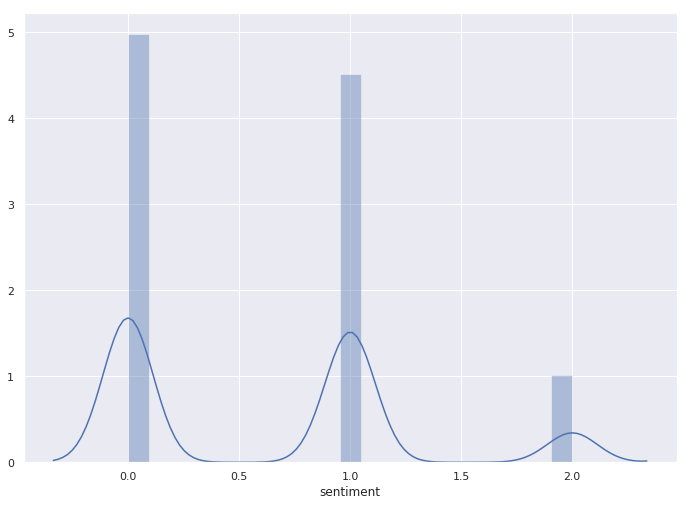

In [46]:
sns.distplot(df_res_pandas['sentiment'])
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Lets do more with Twint

In [30]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append("twint/")

import twint
import numpy as np
from PIL import Image
from os import path

# Solve compatibility issues with notebooks and RunTime errors.
import nest_asyncio
nest_asyncio.apply()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Disable annoying printing

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Get tweets easily

In [3]:
def get_tweets(search, limit=100):
    c = twint.Config()
    c.Search = search
    c.Limit = limit
    c.Pandas = True
    c.Pandas_clean = True

    with HiddenPrints():
        print(twint.run.Search(c))
    return twint.output.panda.Tweets_df[["username","tweet"]]

In [4]:
tweets = get_tweets("AAPL", limit=1000)

In [5]:
tweets.count()

username    10003
tweet       10003
dtype: int64

## Generate word cloud

In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

text = tweets.tweet.values

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("https")
stopwords.add("xa0")
stopwords.add("xa0'")
stopwords.add("bitly")
stopwords.add("bit")
stopwords.add("ly")
stopwords.add("twitter")
stopwords.add("pic")

wordcloud = WordCloud(
    background_color = 'black',
    width = 1000,
    height = 500,
    stopwords = stopwords).generate(str(text))

In [ ]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams['figure.figsize'] = [10, 10]

In [12]:
def generate_word_cloud(tweets):
    
    # Getting the text out of the tweets
    text = tweets.tweet.values
    
    # adding movie script specific stopwords
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("xa0")
    stopwords.add("xa0'")
    stopwords.add("bitly")
    stopwords.add("bit")
    stopwords.add("ly")
    stopwords.add("twitter")
    stopwords.add("pic")

    wordcloud = WordCloud(
        background_color = 'black',
        width = 1000,
        height = 500,
        stopwords = stopwords).generate(str(text))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.rcParams['figure.figsize'] = [10, 10]

## Other example

In [14]:
tweets = get_tweets("Apple", limit=1000)

In [ ]:
generate_word_cloud(tweets)

## Scaling up

In [ ]:
df_result = tweets_sentiment("AAPL", limit=10000)
df_result.show()